In [67]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
import numpy as np
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import StandardScaler

media = [
    'junge Welt',
    "NachDenkSeiten",
    'taz',
    'Süddeutsche Zeitung',
    'stern TV',
    "DER SPIEGEL",
    'Der Tagesspiegel',
    'ARD',
    'tagesschau',
    'ZDF',
    "ZDFheute Nachrichten",
    'Bayerischer Rundfunk',
    'ntv Nachrichten',
    'RTL',
    'FOCUS Online',
    'ZEIT ONLINE',
    'faz',
    'WELT',
    "BILD",
    'NZZ Neue Zürcher Zeitung',
    "Junge Freiheit",
    'COMPACTTV'
]

search_terms = {
    'cdu':['cdu'],
    'csu':['csu'],
    'fdp':['fdp'],
    'grüne':['grüne'],
    'linke':['linke', 'linkspartei'],
    'afd':['afd', 'afg'],
    'spd':['spd'],
}

df = pd.read_pickle('../data/topic.pkl')
df['contains_cdu'] = df['preprocessed'].str.contains('cdu')
df['contains_csu'] = df['preprocessed'].str.contains('csu')
df['contains_fdp'] = df['preprocessed'].str.contains('fdp')
df['contains_grüne'] = df['preprocessed'].str.contains('grüne') 
df['contains_linke'] = df['preprocessed'].str.contains('linke')
df['contains_afd'] = df['preprocessed'].str.contains('afd') | df['preprocessed'].str.contains('afg')
df['contains_spd'] = df['preprocessed'].str.contains('spd')

def extract_party_mentions(input_string, party_strings, n_words=10):
    party_boolean = [False for i in input_string.split()]
    for p in party_strings:
        temp = [string.__contains__(p) for string in input_string.split()]
        party_boolean = [party_boolean|temp for (party_boolean,temp) in zip(party_boolean, temp)]
    party_index = np.where(party_boolean)[0]
    return [" ".join(input_string.split()[party_index[i]-n_words:party_index[i]+(n_words+1)]) for i in range(len(party_index))]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [46]:
tokenizer = AutoTokenizer.from_pretrained("mdraw/german-news-sentiment-bert")
model = AutoModelForSequenceClassification.from_pretrained("mdraw/german-news-sentiment-bert")
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [47]:
classifier("Kanzler Scholz hielt heute eine unfassbar schlechte Rede im Bundestag.")

[{'label': 'neutral', 'score': 0.5967794060707092}]

In [48]:
ind = 6
party = 'spd'
n_words = 10

subset = 'contains_' + party
teststring = df.loc[df[subset]].iloc[ind]['transcript']
extracted_strings = extract_party_mentions(input_string=teststring, party_strings=search_terms[party], n_words=n_words)
print(f'Strings: {extracted_strings}')
print(f'Classification: {classifier(extracted_strings)}')

Strings: ['nicht die grünen und auch nicht die fdp und die spd nicht wir jugendlichen sind es die die forderung voranbringen dankeschön']
Classification: [{'label': 'negative', 'score': 0.5921099185943604}]


In [49]:
def extract_mention_df(party):
    subset = 'contains_' + party
    res_series = df['transcript'].loc[df[subset]].parallel_apply(lambda transcript: extract_party_mentions(input_string=transcript, party_strings=search_terms[party], n_words=10))
    temp = {'medium': df['medium'].loc[df[subset]], 'transcript':res_series}
    res_df = pd.DataFrame(temp).explode(column='transcript')
    res_df.reset_index(inplace=True)
    res_df.dropna(inplace=True)
    res_df.drop(res_df.index[res_df['transcript'] == ''], inplace=True)
    return res_df

In [50]:
def extract_sentiment_df(input_df):
    input_df['sentiment'] = input_df['transcript'].progress_apply(classifier)
    input_df['positive'] = [True if sent[0]['label']=='positive' else False for sent in input_df['sentiment']]
    input_df['neutral'] = [True if sent[0]['label']=='neutral' else False for sent in input_df['sentiment']]
    input_df['negative'] = [True if sent[0]['label']=='negative' else False for sent in input_df['sentiment']]
    input_df['score'] = [sent[0]['score'] for sent in input_df['sentiment']]
    return input_df

In [51]:
def extract_avg_sentiment_df(input_df):
    avg_pos = input_df[input_df['positive']].groupby(['medium'])['score'].median()
    avg_neu = input_df[input_df['neutral']].groupby(['medium'])['score'].median()
    avg_neg = input_df[input_df['negative']].groupby(['medium'])['score'].median()
    output_df = pd.DataFrame(data={'avg_pos':avg_pos, 'avg_neu':avg_neu, 'avg_neg':avg_neg})
    return output_df

In [52]:
def extract_sentiment_counts_df(input_df):
    count_pos = input_df[input_df['positive']].groupby(['medium'])['positive'].sum()
    count_neu = input_df[input_df['neutral']].groupby(['medium'])['neutral'].sum()
    count_neg = input_df[input_df['negative']].groupby(['medium'])['negative'].sum()
    output_df = pd.DataFrame(data={'count_pos':count_pos, 'count_neu':count_neu, 'count_neg':count_neg})
    return output_df

In [53]:
def get_avg_party_sentiment(party):
    df = extract_mention_df(party)
    df = extract_sentiment_df(df)
    df = extract_avg_sentiment_df(df)
    return df['avg_pos'], df['avg_neu'], df['avg_neg']

In [54]:
def get_party_sentiment_counts(party):
    df = extract_mention_df(party)
    df = extract_sentiment_df(df)
    df = extract_sentiment_counts_df(df)
    return df['count_pos'], df['count_neu'], df['count_neg']

In [55]:
'''pos_dict = {}
neu_dict = {}
neg_dict = {}
for party in search_terms.keys():
    pos_dict[party], neu_dict[party], neg_dict[party] = get_avg_party_sentiment(party)'''

'pos_dict = {}\nneu_dict = {}\nneg_dict = {}\nfor party in search_terms.keys():\n    pos_dict[party], neu_dict[party], neg_dict[party] = get_avg_party_sentiment(party)'

In [56]:
'''pos_df = pd.DataFrame(pos_dict)
pos_df = pos_df.loc[media]
pos_df = pos_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
neu_df = pd.DataFrame(neu_dict)
neu_df = neu_df.loc[media]
neu_df = neu_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
neg_df = pd.DataFrame(neg_dict)
neg_df = neg_df.loc[media]
neg_df = neg_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]'''

"pos_df = pd.DataFrame(pos_dict)\npos_df = pos_df.loc[media]\npos_df = pos_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]\nneu_df = pd.DataFrame(neu_dict)\nneu_df = neu_df.loc[media]\nneu_df = neu_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]\nneg_df = pd.DataFrame(neg_dict)\nneg_df = neg_df.loc[media]\nneg_df = neg_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]"

In [57]:
'''pos_df.to_pickle('../assets/pos_df.pkl')
neu_df.to_pickle('../assets/neu_df.pkl')
neg_df.to_pickle('../assets/neg_df.pkl')'''

"pos_df.to_pickle('../assets/pos_df.pkl')\nneu_df.to_pickle('../assets/neu_df.pkl')\nneg_df.to_pickle('../assets/neg_df.pkl')"

In [58]:
pos_df = pd.read_pickle('../assets/pos_df.pkl')
neu_df = pd.read_pickle('../assets/neu_df.pkl')
neg_df = pd.read_pickle('../assets/neg_df.pkl')

[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'median positive sentiment polarity by medium and party')]

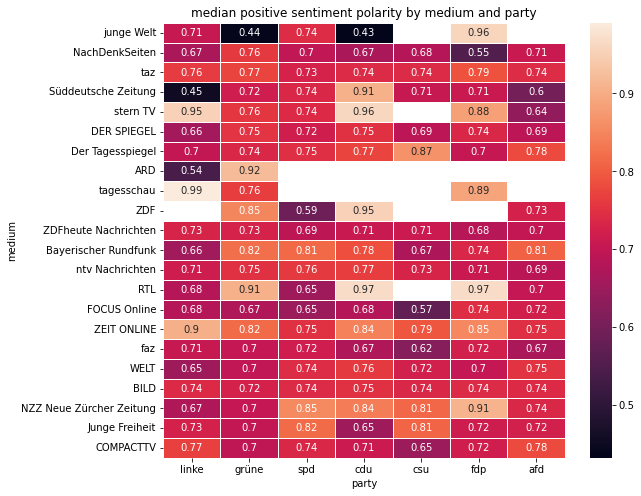

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(pos_df, annot=True, fmt=".2", linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='median positive sentiment polarity by medium and party')

[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'average neutral sentiment polarity by medium and party')]

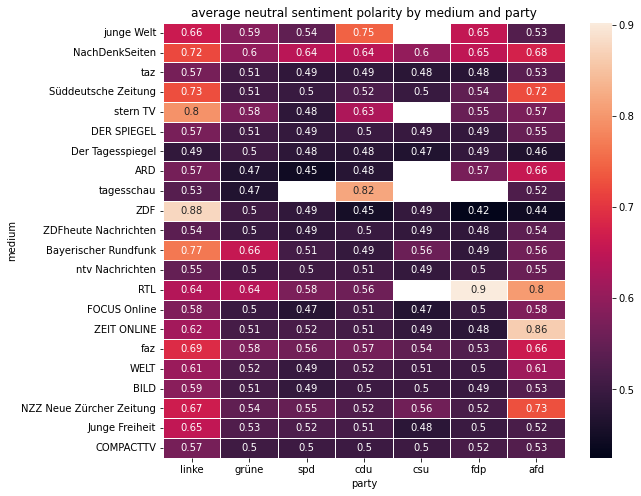

In [60]:
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neu_df, annot=True, fmt=".2", linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='average neutral sentiment polarity by medium and party')

[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'average negative sentiment polarity by medium and party')]

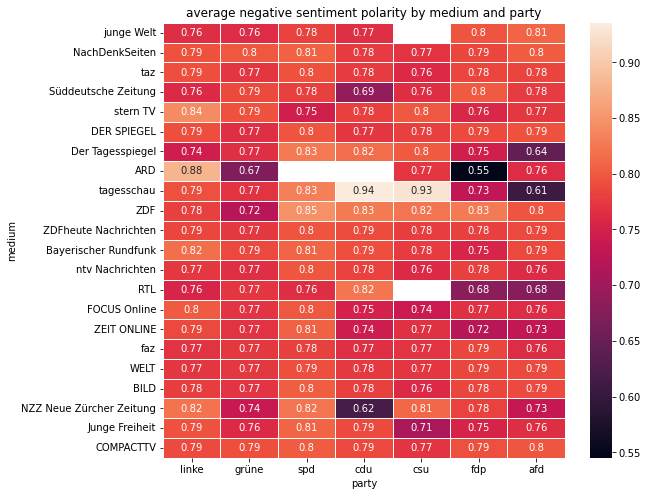

In [61]:
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neg_df, annot=True, fmt=".2", linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='average negative sentiment polarity by medium and party')

In [62]:
pos_counts_dict = {}
neu_counts_dict = {}
neg_counts_dict = {}
for party in search_terms.keys():
    pos_counts_dict[party], neu_counts_dict[party], neg_counts_dict[party] = get_party_sentiment_counts(party)

100%|██████████| 33166/33166 [30:51<00:00, 17.91it/s] 


In [63]:
pos_counts_df = pd.DataFrame(pos_counts_dict)
pos_counts_df = pos_counts_df.loc[media]
pos_counts_df = pos_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
neu_counts_df = pd.DataFrame(neu_counts_dict)
neu_counts_df = neu_counts_df.loc[media]
neu_counts_df = neu_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
neg_counts_df = pd.DataFrame(neg_counts_dict)
neg_counts_df = neg_counts_df.loc[media]
neg_counts_df = neg_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]

In [64]:
pos_counts_df.to_pickle('../assets/pos_counts_df.pkl')
neu_counts_df.to_pickle('../assets/neu_counts_df.pkl')
neg_counts_df.to_pickle('../assets/neg_counts_df.pkl')

[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'sentiment counts by medium and party, standard scaler\n(number of positive mentions - number of negative mentions)')]

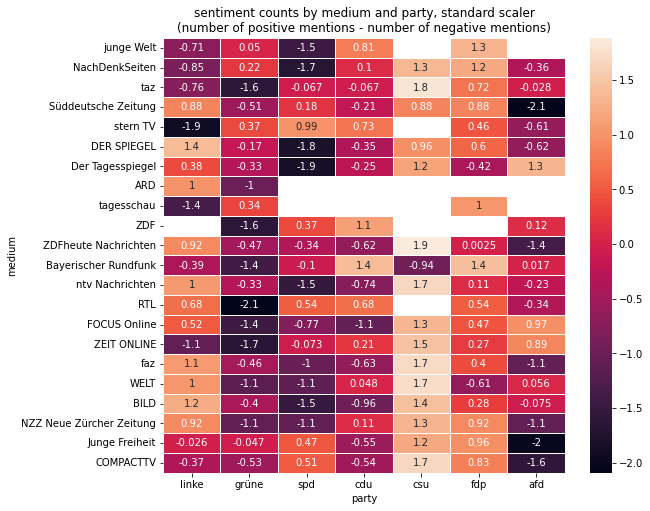

In [69]:
sent_df = (pos_counts_df - neg_counts_df).transpose()
scaler = StandardScaler()
scaled_sent_df = pd.DataFrame(data=scaler.fit_transform(sent_df), columns=sent_df.columns, index=sent_df.index).transpose()
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(scaled_sent_df, annot=True, linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='sentiment counts by medium and party, standard scaler\n(number of positive mentions - number of negative mentions)')